# IMPORTACIÓN LIBRERIAS

In [1]:
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
import seaborn as sns
import re

import warnings
warnings.filterwarnings('ignore')

# CARGA ARCHIVOS

In [2]:
def load_dataset(file_path, file_type=None, separator=None, encoding='utf-8', **kwargs):
    """
    Loads a dataset in different formats, with support for custom separators, encoding, and more options.
    """
    # If the file type is not specified, infer from file extension
    if not file_type:
        file_type = file_path.split('.')[-1].lower()

    # Load according to the file type
    if file_type == 'csv':
        return pd.read_csv(file_path, sep=separator or ',', encoding=encoding, **kwargs)
    elif file_type in ['xls', 'xlsx']:
        return pd.read_excel(file_path, **kwargs)
    elif file_type == 'json':
        return pd.read_json(file_path, encoding=encoding, **kwargs)
    else:
        raise ValueError(f"File format '{file_type}' not supported. Use 'csv', 'excel', or 'json'.")

In [10]:
df_servicios = load_dataset('../data/Fisio-Nutri 01.09.2024 a 01.09.2025 FORMATO BUENO.xlsx', sheet_name="adaptado")

#### CONVERTIR COLUMNAS Y FILAS

In [9]:
def preparar_datos_iniciales(df: pd.DataFrame, columnas_a_eliminar: list,   columnas_a_renombrar: dict,
    columnas_numericas: list, columnas_fechas: list) -> pd.DataFrame:
    """
    Prepara un DataFrame para análisis exploratorio de datos (EDA).
    
    Parámetros:
        df (pd.DataFrame): DataFrame original
        columnas_a_eliminar (list): Columnas que se eliminarán del DataFrame
        columnas_a_renombrar (dict): Diccionario con columnas a renombrar {original: nuevo_nombre}
        columnas_numericas (list): Columnas que deben convertirse a tipo numérico
        columnas_fechas (list): Columnas que deben convertirse a tipo datetime
    
    Retorna:
        pd.DataFrame: DataFrame transformado
    """
    df_eda = df.copy()

    # Eliminar columnas
    df_eda.drop(columns=columnas_a_eliminar, inplace=True, errors='ignore')

    # Renombrar columnas
    df_eda.rename(columns=columnas_a_renombrar, inplace=True)

    # Conversión de columnas numéricas
    for col in columnas_numericas:
        if col in df_eda.columns:
            df_eda[col] = pd.to_numeric(df_eda[col], errors='coerce')

    # Conversión de columnas de fecha
    for col in columnas_fechas:
        if col in df_eda.columns:
            df_eda[col] = pd.to_datetime(df_eda[col], errors='coerce', dayfirst=True)

    return df_eda

In [12]:
columnas_a_eliminar = []
columnas_a_renombrar = {}
columnas_numericas = ['IdPersona','Importe_2024_servicios','Cantidad_2024_servicios', 'Importe_2025_servicios',
                   'Cantidad_2025_servicios', 'Importe_total_pagado_servicios', 'Cantidad_total_pagado_servicios']
columnas_fechas= []

df_servicios = preparar_datos_iniciales(df_servicios, columnas_a_eliminar, columnas_a_renombrar,
    columnas_numericas,   columnas_fechas)

In [13]:
df_servicios.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53 entries, 0 to 52
Data columns (total 9 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   IdPersona                        53 non-null     int64  
 1   Concepto                         53 non-null     object 
 2   Importe_2024_servicios           21 non-null     float64
 3   Cantidad_2024_servicios          21 non-null     float64
 4   Importe_2025_servicios           37 non-null     float64
 5   Cantidad_2025_servicios          37 non-null     float64
 6   Importe_total_pagado_servicios   53 non-null     float64
 7   Cantidad_total_pagado_servicios  53 non-null     int64  
 8   TipoServicio                     53 non-null     object 
dtypes: float64(5), int64(2), object(2)
memory usage: 3.9+ KB


In [14]:
def eda_basica(df: pd.DataFrame, nombre_df: str = "DataFrame") -> None:
    """
    Realiza un análisis exploratorio básico sobre un DataFrame:
    - Identifica variables numéricas y categóricas
    - Detecta valores nulos y muestra una visualización si los hay
    - Revisa duplicados (filas y columnas)

    Parámetros:
        df (pd.DataFrame): El DataFrame a analizar
        nombre_df (str): Nombre para mostrar del DataFrame (opcional)
    """
    print(f"\n📋 Análisis EDA básico de: {nombre_df}")

    # 1. Tipos de variables
    print("\n📌 Tipos de Variables:")
    num_vbles = df.select_dtypes(include='number').columns.tolist()
    cat_vbles = df.select_dtypes(exclude='number').columns.tolist()
    print(f"🔢 Variables Numéricas: {num_vbles}")
    print(f"🔠 Variables Categóricas: {cat_vbles}")

    # 2. Valores nulos
    print("\n🕳️ Variables con valores nulos:")
    missing = df.isnull().sum()
    missing = missing[missing > 0].sort_values(ascending=False)
    missing_percentage = (missing / len(df)) * 100
    missing_df = pd.DataFrame({
        'Total Missing': missing,
        'Percentage Missing': missing_percentage
    })

    if not missing.empty:
        display(missing_df)
        plt.figure(figsize=(10, 6))
        missing.plot(kind='barh', color='salmon')
        plt.title("Variables con Valores Nulos")
        plt.xlabel("Cantidad de valores nulos")
        plt.gca().invert_yaxis()
        plt.grid(True, axis='x', linestyle='--', alpha=0.7)
        plt.show()
    else:
        print("✅ No hay valores nulos en el dataset.")

    # 3. Filas duplicadas
    print("\n📎 Filas duplicadas:")
    duplicadas = df.duplicated().sum()
    if duplicadas > 0:
        print(f"🔴 Hay {duplicadas} filas duplicadas.")
        display(df[df.duplicated()])
    else:
        print("✅ No hay filas duplicadas.")

    # 4. Columnas duplicadas
    print("\n📎 Columnas duplicadas:")
    columnas_duplicadas = df.T.duplicated().sum()
    if columnas_duplicadas > 0:
        print(f"🔴 Hay {columnas_duplicadas} columnas duplicadas.")
    else:
        print("✅ No hay columnas duplicadas.")


📋 Análisis EDA básico de: Clientes con servicios extra

📌 Tipos de Variables:
🔢 Variables Numéricas: ['IdPersona', 'Importe_2024_servicios', 'Cantidad_2024_servicios', 'Importe_2025_servicios', 'Cantidad_2025_servicios', 'Importe_total_pagado_servicios', 'Cantidad_total_pagado_servicios']
🔠 Variables Categóricas: ['Concepto', 'TipoServicio']

🕳️ Variables con valores nulos:


,Total Missing,Percentage Missing
Importe_2024_servicios,32,60.377358
Cantidad_2024_servicios,32,60.377358
Importe_2025_servicios,16,30.188679
Cantidad_2025_servicios,16,30.188679


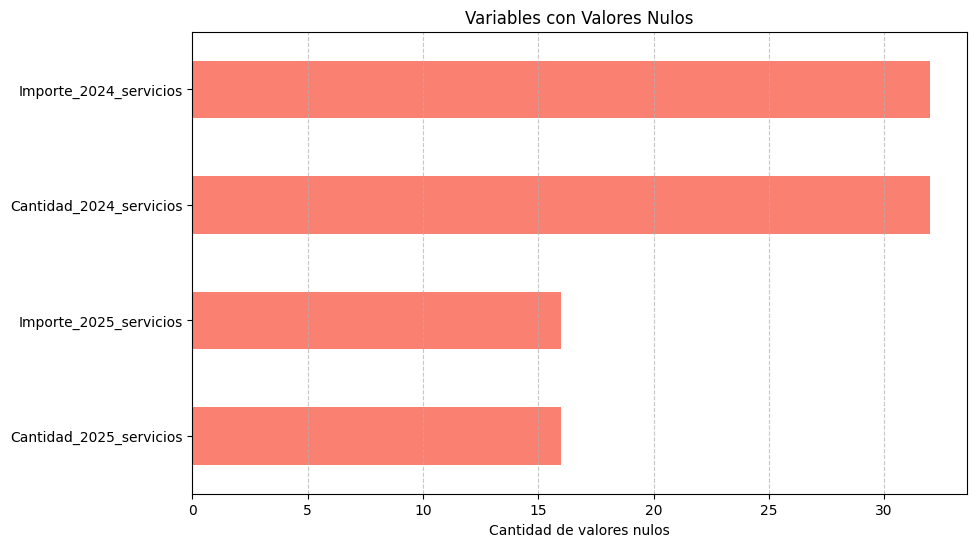


📎 Filas duplicadas:
✅ No hay filas duplicadas.

📎 Columnas duplicadas:
✅ No hay columnas duplicadas.


In [ ]:
eda_basica(, nombre_df="Clientes con servicios extra")

Como son valores dependiendo de si compra o no los diferentes usuarios se reemplaza los valores nulos de cada columa y fila por un 0


In [18]:
df_servicios=df_servicios.fillna(0)
df_servicios.isnull().sum()

IdPersona                          0
Concepto                           0
Importe_2024_servicios             0
Cantidad_2024_servicios            0
Importe_2025_servicios             0
Cantidad_2025_servicios            0
Importe_total_pagado_servicios     0
Cantidad_total_pagado_servicios    0
TipoServicio                       0
dtype: int64

## FEATURE ENGINEERING

In [19]:
def agregar_servicios(df_servicios):
    """
    Agrupa el DataFrame de servicios por IdPersona y calcula:
    - Número de conceptos únicos
    - Número de tipos de servicio únicos

    Parámetros:
    - df_servicios: DataFrame con columnas 'IdPersona', 'Concepto', 'TipoServicio'

    Retorna:
    - df_agregado: DataFrame con columnas 'IdPersona', 'Total_conceptos_unicos', 'Total_tipos_servicios_unicos'
    """
    df_agregado = df_servicios.groupby('IdPersona').agg({
        'Concepto': 'nunique',
        'TipoServicio': 'nunique'
    }).reset_index()

    df_agregado = df_agregado.rename(columns={
        'Concepto': 'Total_conceptos_unicos',
        'TipoServicio': 'Total_tipos_servicios_unicos'
    })

    return df_agregado

In [20]:
df_servicios_agregados = agregar_servicios(df_servicios)
df_servicios_agregados

,IdPersona,Total_conceptos_unicos,Total_tipos_servicios_unicos
0,20976,1,1
1,25409,1,1
2,29665,1,1
3,46715,1,1
4,46901,1,1
5,46978,1,1
6,90023,1,1
7,92269,3,2
8,92364,1,1
9,95199,1,1


In [21]:
def aplicar_one_hot_encoding_servicios(df_servicios):
    """
    Aplica One-Hot Encoding a las columnas 'Concepto' y 'TipoServicio' y concatena las columnas resultantes
    al DataFrame original.

    Parámetros:
    - df_servicios: DataFrame con las columnas 'Concepto' y 'TipoServicio'

    Retorna:
    - df_servicios_encoded: DataFrame con las columnas originales más las columnas one-hot encoded
    """
    df_one_hot_concepto = pd.get_dummies(df_servicios['Concepto'], prefix='Concepto', drop_first=False)
    df_one_hot_tipo_servicio = pd.get_dummies(df_servicios['TipoServicio'], prefix='TipoServicio', drop_first=False)

    df_servicios_encoded = pd.concat([df_servicios, df_one_hot_concepto, df_one_hot_tipo_servicio], axis=1)

    return df_servicios_encoded

In [22]:
df_servicios_encoded = aplicar_one_hot_encoding_servicios(df_servicios)


In [23]:
def agregar_y_unir_servicios(df_servicios_encoded, df_agregado):
    """
    Agrupa por 'IdPersona' sumando las columnas one-hot encoded,
    luego une con df_agregado y limpia columnas innecesarias,
    finalmente añade la columna 'UsoServiciosExtra' con valor True.

    Parámetros:
    - df_servicios_encoded: DataFrame con columnas one-hot encoded y 'IdPersona'
    - df_agregado: DataFrame con agregados por 'IdPersona' (total conceptos y tipos)

    Retorna:
    - df_servicios_final: DataFrame con features agregados y limpieza hecha
    """
    # Agrupar sumando one-hot encoded
    df_encoded_grouped = df_servicios_encoded.groupby('IdPersona').agg('sum').reset_index()

    # Merge con df_agregado
    df_servicios_final = pd.merge(df_encoded_grouped, df_agregado, on='IdPersona', how='left')

    # Eliminar columnas originales no necesarias (si existen)
    for col in ['Concepto', 'TipoServicio']:
        if col in df_servicios_final.columns:
            df_servicios_final = df_servicios_final.drop(columns=[col])

    # Añadir columna de uso de servicios extra
    df_servicios_final["UsoServiciosExtra"] = True

    return df_servicios_final

In [24]:
df_servicios_final = agregar_y_unir_servicios(df_servicios_encoded, df_servicios_agregados)

In [25]:
df_servicios_final.head()

,IdPersona,Importe_2024_servicios,Cantidad_2024_servicios,Importe_2025_servicios,Cantidad_2025_servicios,Importe_total_pagado_servicios,Cantidad_total_pagado_servicios,Concepto_ENTRENADOR PERSONAL 1 /2 SESSIO ABONAT,Concepto_ENTRENADOR PERSONAL 1 SESSIO,Concepto_ENTRENADOR PERSONAL 1 SESSIÓ ABONAT,...,Concepto_NUTRI PACK 3 SEGUIMENTS ABONAT,Concepto_NUTRI VISITA DE SEGUIMENT ABONAT,Concepto_PACK 3 SEGUIMENTS ABONAT,Concepto_PACK NUTRICIÓ (2 VISITES) ABONAT,TipoServicio_ENTRENAMENTS PERSONALS,TipoServicio_FISIOTERÀPIA,TipoServicio_NUTRICIÓ,Total_conceptos_unicos,Total_tipos_servicios_unicos,UsoServiciosExtra
0,20976,0.00,0.0,44.70,1.0,44.70,1,0,0,0,...,0,0,0,0,0,1,0,1,1,True
1,25409,0.00,0.0,26.90,1.0,26.90,1,0,0,0,...,0,0,0,0,0,1,0,1,1,True
2,29665,0.00,0.0,44.70,1.0,44.70,1,0,0,1,...,0,0,0,0,1,0,0,1,1,True
3,46715,438.75,2.0,673.50,3.0,1112.25,5,0,0,0,...,0,0,0,0,0,1,0,1,1,True
4,46901,0.00,0.0,236.85,1.0,236.85,1,0,0,0,...,0,0,0,0,1,0,0,1,1,True


In [26]:
def preparar_servicios_final(df_servicios_final):
    """
    Ajusta tipos de datos en el dataframe final de servicios:
    - Convierte ciertas columnas numéricas a int
    - Convierte columnas de conceptos (one-hot) a booleano

    Parámetros:
    - df_servicios_final: DataFrame con columnas a convertir

    Retorna:
    - df_servicios_final modificado con tipos correctos
    """
    # Columnas que convertir a int (asegúrate que existan)
    int_cols = [
        'Cantidad_2024_servicios',
        'Cantidad_2025_servicios',
        'Cantidad_total_pagado_servicios',
        'TipoServicio_ENTRENAMENTS PERSONALS',
        'TipoServicio_FISIOTERÀPIA',
        'TipoServicio_NUTRICIÓ'
    ]
    
    for col in int_cols:
        if col in df_servicios_final.columns:
            df_servicios_final[col] = df_servicios_final[col].astype(int)
    
    # Convertir columnas de conceptos a booleano
    concepto_cols = [col for col in df_servicios_final.columns if col.startswith('Concepto_')]
    if concepto_cols:
        df_servicios_final[concepto_cols] = df_servicios_final[concepto_cols].astype(bool)

    return df_servicios_final


In [27]:
df_servicios_final = preparar_servicios_final(df_servicios_final)


In [28]:
df_servicios_final.sample(5)

,IdPersona,Importe_2024_servicios,Cantidad_2024_servicios,Importe_2025_servicios,Cantidad_2025_servicios,Importe_total_pagado_servicios,Cantidad_total_pagado_servicios,Concepto_ENTRENADOR PERSONAL 1 /2 SESSIO ABONAT,Concepto_ENTRENADOR PERSONAL 1 SESSIO,Concepto_ENTRENADOR PERSONAL 1 SESSIÓ ABONAT,...,Concepto_NUTRI PACK 3 SEGUIMENTS ABONAT,Concepto_NUTRI VISITA DE SEGUIMENT ABONAT,Concepto_PACK 3 SEGUIMENTS ABONAT,Concepto_PACK NUTRICIÓ (2 VISITES) ABONAT,TipoServicio_ENTRENAMENTS PERSONALS,TipoServicio_FISIOTERÀPIA,TipoServicio_NUTRICIÓ,Total_conceptos_unicos,Total_tipos_servicios_unicos,UsoServiciosExtra
20,107691,80.20,2,0.0,0,80.20,2,False,False,False,...,True,False,False,False,0,0,2,2,1,True
21,107781,0.00,0,176.9,2,176.90,2,False,False,False,...,False,False,False,True,0,1,1,2,2,True
23,108066,0.00,0,550.0,2,550.00,2,False,False,False,...,False,False,False,False,2,0,0,2,1,True
29,110807,197.35,1,0.0,0,197.35,1,False,False,False,...,False,False,False,False,1,0,0,1,1,True
2,29665,0.00,0,44.7,1,44.70,1,False,False,True,...,False,False,False,False,1,0,0,1,1,True


# GUARDAMOS DATAFRAME RESULTANTE 

Ese dataframe se guarda para reutilizarse posteriormente para crear el archivo final para el modelo. Se guarda en formato CSV.

In [29]:
# Guardar el DataFrame en un archivo CSV
df_servicios_final.to_csv('../data/servicios_final.csv', index=False)